In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

In [3]:
from pathlib import Path
sns.set_context('notebook')
sns.set_style('darkgrid')
paper_path = Path("/home/salabed/workspace/latex/eurosys-2021/figs")

In [7]:
dataset_x = pd.read_csv("params.csv", index_col = 0)
dataset_y = pd.read_csv("slo.csv", index_col = 0)
all_dataset = pd.concat([dataset_x, dataset_y],axis=1)

In [5]:
# Correlation between features and output

dataset_x['iops'] = dataset_y['mixgraph_iops']

In [ ]:
plt.figure(figsize=(12,10))

corr = dataset_x.corr()
sns.heatmap(corr, annot=True, cmap = plt.cm.Reds)

In [6]:
## Visualize the parameters distribution

# sns.pairplot(dataset_x)

dataset_x["block_size"].describe()

count       700.000000
mean     205620.637143
std      152561.719334
min           1.000000
25%       60922.250000
50%      178760.500000
75%      336553.000000
max      500000.000000
Name: block_size, dtype: float64

In [6]:
flushing_dataset = dataset_x[["write_buffer_size", "max_write_buffer_number", "min_write_buffer_number_to_merge"]]
flushing_dataset

,write_buffer_size,max_write_buffer_number,min_write_buffer_number_to_merge
0,130000000,11,2
1,130000000,10,2
2,130000000,10,2
3,130000000,11,2
4,130000000,11,2
...,...,...,...
295,130000000,128,32
296,130000000,128,32
297,130000000,84,32
298,130000000,95,32


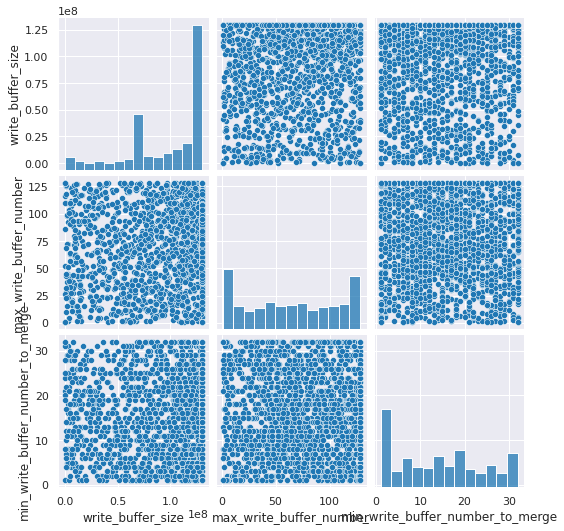

In [7]:
sns.pairplot(flushing_dataset)

In [15]:
# target_var = "mixgraph_iops"
target_var = "level0_stop_writes_trigger"
### Correlation between target features
feature_corr = all_dataset.corr()
# sns.heatmap(feature_corr, annot=True, cmap = plt.cm.Reds)
# target is mixgraph_iops
cor_target = abs(feature_corr[target_var])#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
len(relevant_features)
for feature in relevant_features.keys():
    print(feature)

level0_stop_writes_trigger
FileReadStatsLevel1_count
FileReadStatsLevel1_average
FileReadStatsLevel1_stddev
FileReadStatsLevel1_min
FileReadStatsLevel1_median
FileReadStatsLevel1_max
FileReadStatsLevel1_p50
FileReadStatsLevel1_p75
FileReadStatsLevel1_p99
FileReadStatsLevel1_p99_9
FileReadStatsLevel1_p99_99
level_1_size_mb
level_1_score
level_1_read_gb
level_1_rnp1_gb
level_1_write_gb
level_1_moved_gb
level_1_w_amp
level_1_comp_sec
level_1_comp_merge_cpu_sec
level_1_comp_cnt
level_1_key_in
level_1_key_drop


In [8]:
feature_corr = all_dataset.corr()
cor_target = abs(feature_corr["mixgraph_iops"])#Selecting highly correlated features
mixgraph_iops_corr = cor_target[cor_target>0.5]

In [36]:
mixgraph_iops_corr.keys().tolist()

['write_buffer_size',
 'mem_p99',
 'mixgraph_latency',
 'mixgraph_iops',
 'mixgraph_io_size',
 'FileReadStatsLevel0_average',
 'FileReadStatsLevel0_min',
 'FileReadStatsLevel0_median',
 'FileReadStatsLevel0_p50',
 'FileReadStatsLevel0_p75',
 'rocksdb_memtable_miss_count',
 'rocksdb_number_keys_written_count',
 'rocksdb_number_keys_read_count',
 'rocksdb_bytes_written_count',
 'rocksdb_number_db_seek_count',
 'rocksdb_number_db_next_count',
 'rocksdb_number_db_seek_found_count',
 'rocksdb_number_db_next_found_count',
 'rocksdb_db_iter_bytes_read_count',
 'rocksdb_wal_bytes_count',
 'rocksdb_write_self_count',
 'rocksdb_write_wal_count',
 'rocksdb_number_iter_skip_count',
 'rocksdb_num_iterator_created_count',
 'rocksdb_num_iterator_deleted_count',
 'rocksdb_db_get_micros_p50',
 'rocksdb_db_get_micros_count',
 'rocksdb_db_get_micros_sum',
 'rocksdb_db_write_micros_p50',
 'rocksdb_db_write_micros_p95',
 'rocksdb_db_write_micros_p99',
 'rocksdb_db_write_micros_count',
 'rocksdb_db_write_mi

In [9]:
def list_relevant_to_iops(features: list[str]) -> list[str]:
    """ Return a list of features from input features that are relevant to iops """
    result = []
    for f in features:
        if f in mixgraph_iops_corr:
            result.append(f)
    return result

In [15]:
def param_to_all_relevant_features_with_impact(param: str) -> list[str]:
    feature_corr = all_dataset.corr()
    cor_target = abs(feature_corr[param])#Selecting highly correlated features
    relevant_features = cor_target[cor_target>0.5]
    return list_relevant_to_iops(relevant_features.keys().tolist())

investigate_var = "level0_stop_writes_trigger"
param_to_all_relevant_features_with_impact(investigate_var)

['FileReadStatsLevel1_min',
 'FileReadStatsLevel1_p75',
 'level_1_out_files',
 'level_1_rn_gb',
 'level_1_wnew_gb',
 'level_1_key_drop']

<ipython-input-90-a1c25be4115f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flushing_dataset['iops'] = dataset_y['mixgraph_iops']


<AxesSubplot:>

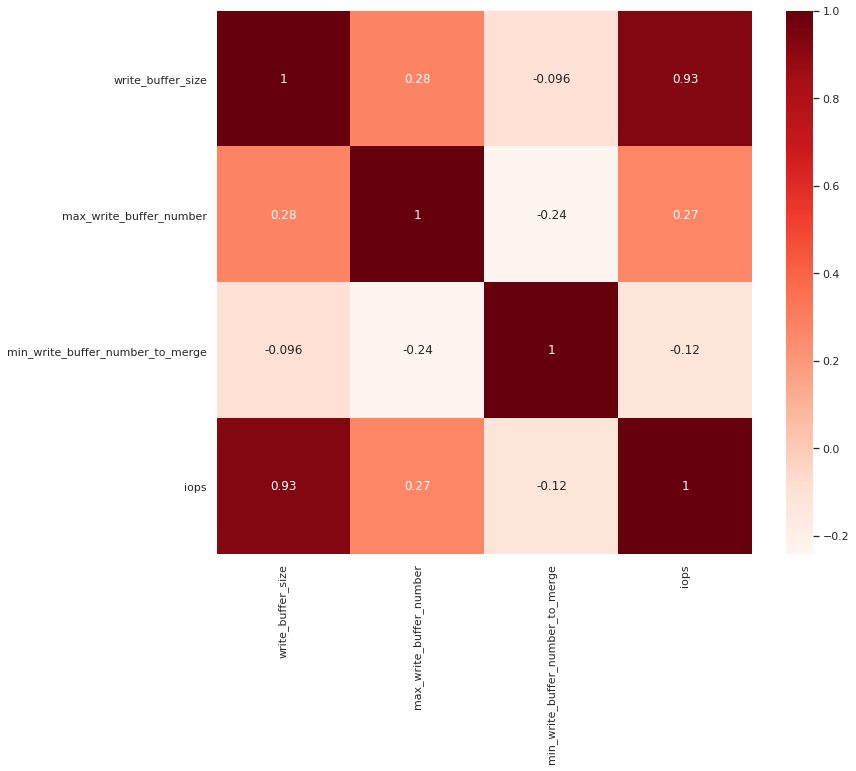

In [90]:
# correlation between input and output?
flushing_dataset['iops'] = dataset_y['mixgraph_iops']
in_corr = flushing_dataset.corr()

plt.figure(figsize=(12,10))
sns.heatmap(in_corr, annot=True, cmap = plt.cm.Reds)
## no direct correlation?

In [115]:
test_dataset = dataset_y[relevant_features.keys().tolist()]
test_dataset = pd.concat([flushing_dataset, test_dataset],axis=1)
test_dataset = test_dataset.dropna(axis=1)

In [116]:
test_corr = test_dataset.fillna(0).corr()
target_corr = abs(test_corr["write_buffer_size"])
corr_2 = abs(test_corr["max_write_buffer_number"])
corr_3 = abs(test_corr["min_write_buffer_number_to_merge"])
write_buffer_corr = (target_corr > 0.5)
max_buffer_num_corr = (corr_2 > 0.5)
merge_num_corr = (corr_3 >0.5)
relevant_subtarget = test_corr[write_buffer_corr & max_buffer_num_corr & merge_num_corr]
for subtarget in relevant_subtarget:
    print(subtarget)

write_buffer_size
max_write_buffer_number
min_write_buffer_number_to_merge
iops
mem_p99
mixgraph_latency
mixgraph_iops
mixgraph_io_size
rocksdb_memtable_miss_count
rocksdb_number_keys_written_count
rocksdb_number_keys_read_count
rocksdb_bytes_written_count
rocksdb_number_db_seek_count
rocksdb_number_db_next_count
rocksdb_number_db_seek_found_count
rocksdb_number_db_next_found_count
rocksdb_db_iter_bytes_read_count
rocksdb_wal_bytes_count
rocksdb_write_self_count
rocksdb_write_wal_count
rocksdb_number_iter_skip_count
rocksdb_num_iterator_created_count
rocksdb_num_iterator_deleted_count
rocksdb_db_get_micros_p50
rocksdb_db_get_micros_p95
rocksdb_db_get_micros_p99
rocksdb_db_get_micros_count
rocksdb_db_get_micros_sum
rocksdb_db_write_micros_p50
rocksdb_db_write_micros_p95
rocksdb_db_write_micros_p99
rocksdb_db_write_micros_count
rocksdb_db_write_micros_sum
rocksdb_db_seek_micros_p50
rocksdb_db_seek_micros_p95
rocksdb_db_seek_micros_p99
rocksdb_db_seek_micros_count
rocksdb_db_seek_micros_s

In [152]:
write_buffer_params = ["write_buffer_size", "max_write_buffer_number", "min_write_buffer_number_to_merge"]

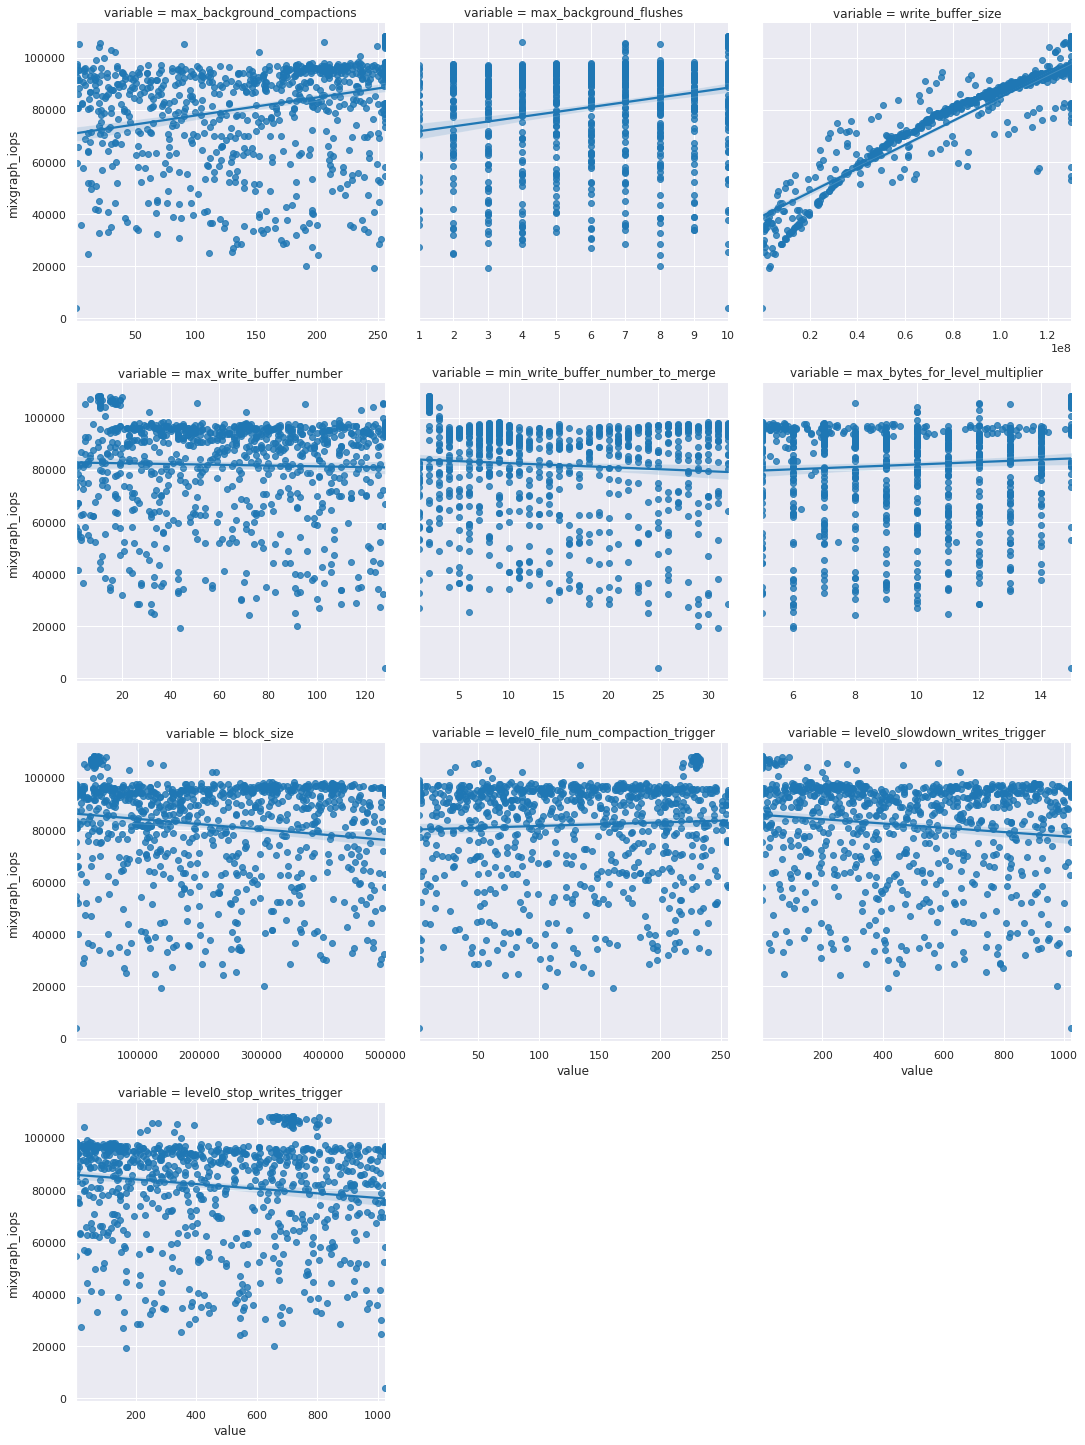

In [8]:
from autorocks.envs.rocksdb.space import RocksDBParamsSpaceV1

params_to_iops = all_dataset.melt(id_vars = ["mixgraph_iops"],
                         value_vars = RocksDBParamsSpaceV1().params_name(),
                         )
sns.lmplot(data=params_to_iops, x='value', y='mixgraph_iops',
           col='variable', col_wrap=3,
           sharex=False, sharey=True)

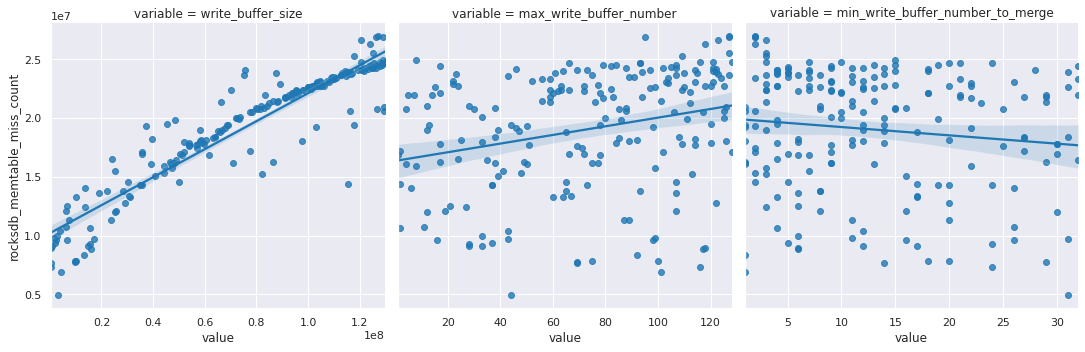

In [158]:
target = "rocksdb_memtable_miss_count"
buffer_params = all_dataset.melt(id_vars = [target],
             value_vars =write_buffer_params,
             )
sns.lmplot(data=buffer_params, x='value', y=target,
           col='variable', col_wrap=3,
           sharex=False, sharey=True)

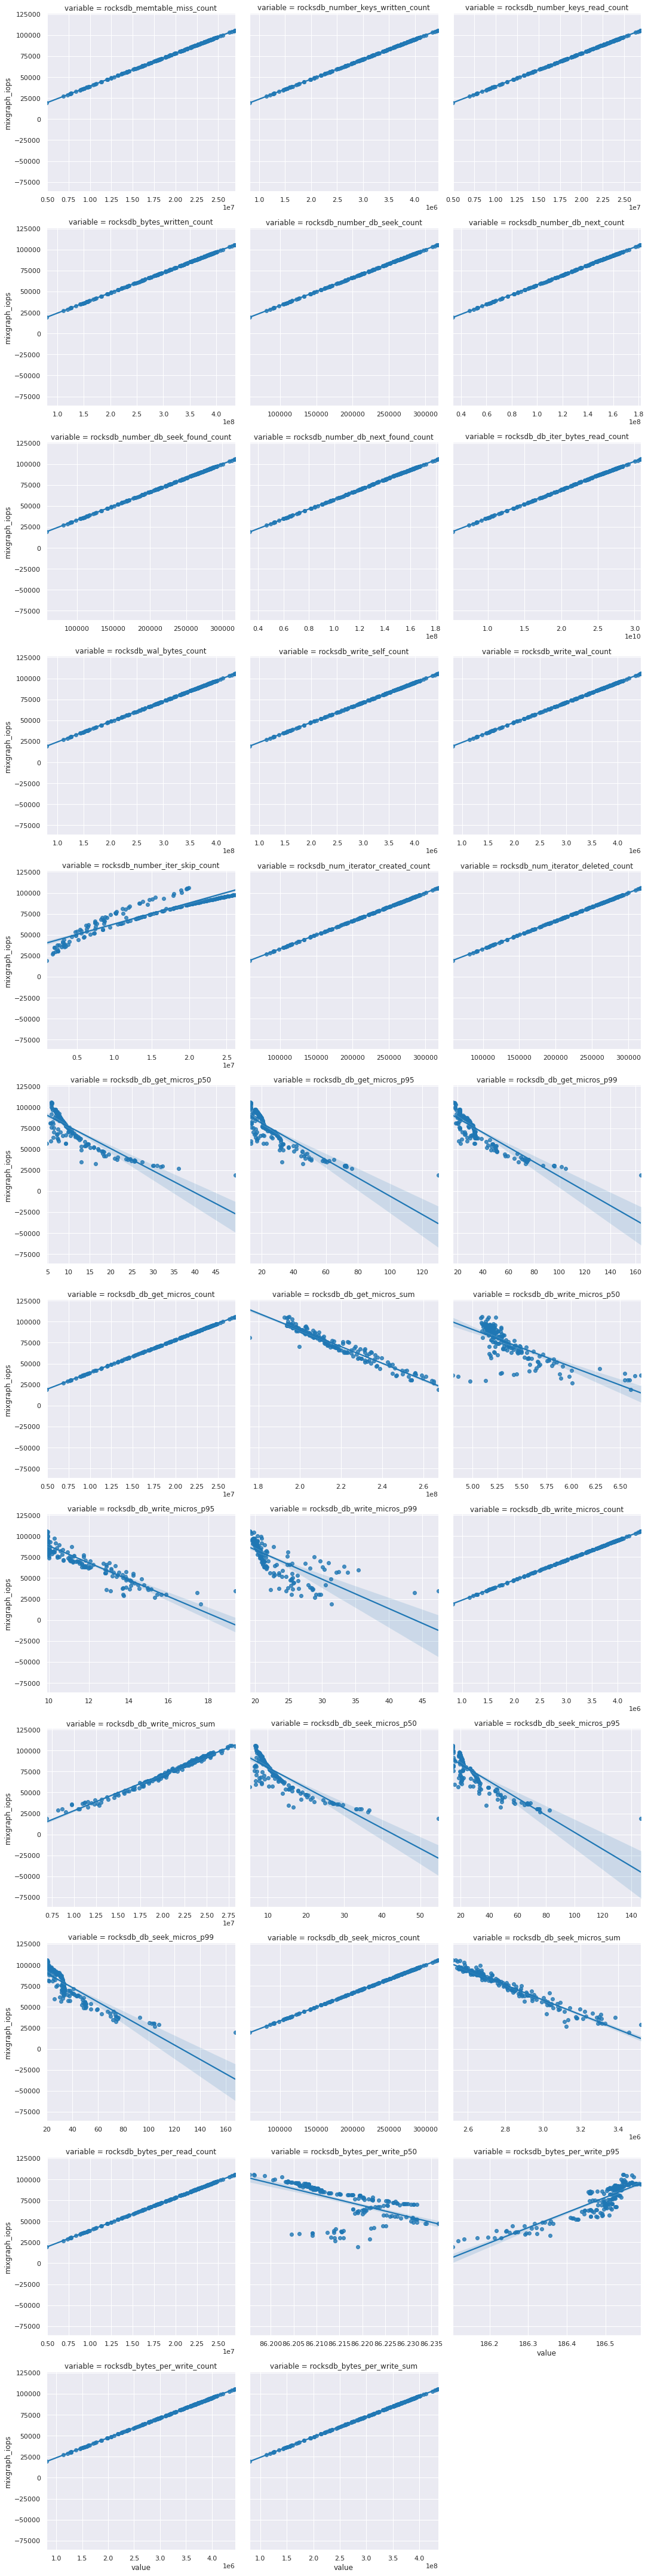

In [168]:
relevant_features =['rocksdb_memtable_miss_count',
 'rocksdb_number_keys_written_count',
 'rocksdb_number_keys_read_count',
 'rocksdb_bytes_written_count',
 'rocksdb_number_db_seek_count',
 'rocksdb_number_db_next_count',
 'rocksdb_number_db_seek_found_count',
 'rocksdb_number_db_next_found_count',
 'rocksdb_db_iter_bytes_read_count',
 'rocksdb_wal_bytes_count',
 'rocksdb_write_self_count',
 'rocksdb_write_wal_count',
 'rocksdb_number_iter_skip_count',
 'rocksdb_num_iterator_created_count',
 'rocksdb_num_iterator_deleted_count',
 'rocksdb_db_get_micros_p50',
 'rocksdb_db_get_micros_p95',
 'rocksdb_db_get_micros_p99',
 'rocksdb_db_get_micros_count',
 'rocksdb_db_get_micros_sum',
 'rocksdb_db_write_micros_p50',
 'rocksdb_db_write_micros_p95',
 'rocksdb_db_write_micros_p99',
 'rocksdb_db_write_micros_count',
 'rocksdb_db_write_micros_sum',
 'rocksdb_db_seek_micros_p50',
 'rocksdb_db_seek_micros_p95',
 'rocksdb_db_seek_micros_p99',
 'rocksdb_db_seek_micros_count',
 'rocksdb_db_seek_micros_sum',
 'rocksdb_bytes_per_read_count',
 'rocksdb_bytes_per_write_p50',
 'rocksdb_bytes_per_write_p95',
 'rocksdb_bytes_per_write_count',
 'rocksdb_bytes_per_write_sum']
target = 'mixgraph_iops'
correlated_features = all_dataset.melt(id_vars = [target],
                                       value_vars = relevant_features
                                       )
sns.lmplot(data=correlated_features, x='value', y=target,
           col='variable', col_wrap=3,
           sharex=False, sharey=True)

<AxesSubplot:xlabel='iops', ylabel='Count'>

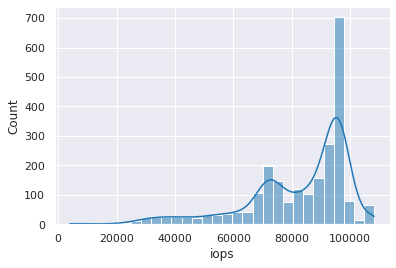

In [8]:
sns.histplot(data=dataset_x, x="iops", kde=True)

In [5]:
dataset_random = pd.read_csv("slo_random.csv", index_col = 0)

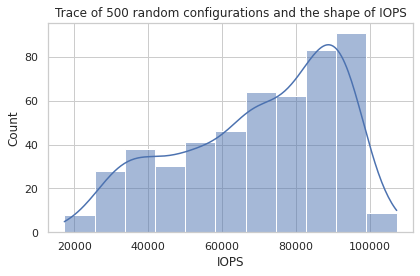

In [6]:
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots()
sns.histplot(data=dataset_random, x='mixgraph_iops', kde=True)
ax.set(xlabel='IOPS', ylabel ='Count', title='Trace of 500 random configurations and the shape of IOPS')
plt.tight_layout()
fig.savefig(paper_path / 'random_iops.pdf', format='pdf', dpi=300)


In [4]:
random_params = pd.read_csv("params_random.csv", index_col = 0)
random_params['iops'] = dataset_random['mixgraph_iops']
corr = random_params.corr()

NameError: name 'dataset_random' is not defined

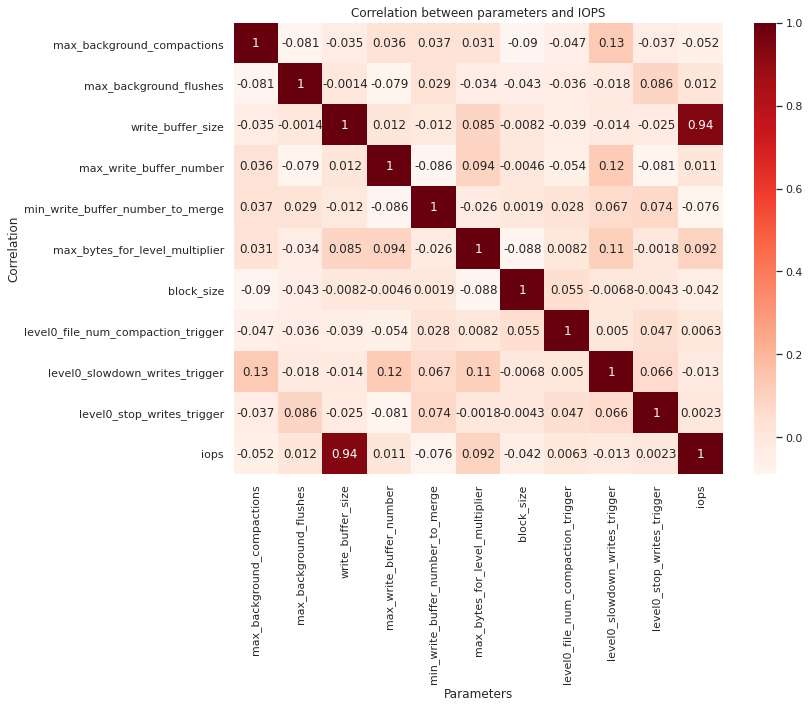

In [25]:
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(corr, annot=True, cmap = plt.cm.Reds)
ax.set(xlabel='Parameters', ylabel ='Correlation',
       title='Correlation between parameters and IOPS')
plt.tight_layout()
fig.savefig(paper_path / 'random_corr.pdf', format='pdf', dpi=300)

In [15]:
from autorocks.envs.rocksdb.space import RocksDBParamsSpaceV1

from botorch.utils.transforms import normalize, standardize
import torch
bounds = torch.from_numpy(RocksDBParamsSpaceV1().bounds()).T

dataset_x_normalized = pd.DataFrame(data= normalize(torch.tensor(dataset_x.values),
                                                         bounds=bounds).detach().numpy(),
                                    columns = RocksDBParamsSpaceV1().params_name()
                                    )

dataset_x_normalized['iops'] = standardize(torch.tensor(dataset_y['mixgraph_iops'].values)).detach().numpy()

dataset_x_normalized

,max_background_compactions,max_background_flushes,write_buffer_size,max_write_buffer_number,min_write_buffer_number_to_merge,max_bytes_for_level_multiplier,block_size,level0_file_num_compaction_trigger,level0_slowdown_writes_trigger,level0_stop_writes_trigger,iops
0,1.000000,1.000000,1.000000,0.078740,0.032258,1.0,0.059094,0.894118,0.000000,0.699902,1.334038
1,1.000000,1.000000,1.000000,0.070866,0.032258,1.0,0.075596,0.886275,0.000000,0.597263,1.235745
2,1.000000,1.000000,1.000000,0.070866,0.032258,1.0,0.073328,0.898039,0.000000,0.648094,1.334645
3,1.000000,1.000000,1.000000,0.078740,0.032258,1.0,0.060766,0.894118,0.000000,0.698925,1.289902
4,1.000000,1.000000,1.000000,0.078740,0.032258,1.0,0.061258,0.894118,0.000000,0.698925,1.327053
...,...,...,...,...,...,...,...,...,...,...,...
895,0.525490,0.666667,0.464962,0.188976,0.612903,0.2,0.295517,0.674510,0.632454,0.696970,-0.554064
896,0.058824,0.000000,0.898471,0.960630,0.419355,0.6,0.233270,0.172549,0.167155,0.216031,0.562884
897,0.666667,0.111111,0.841736,0.708661,0.387097,0.6,0.041160,0.490196,0.192571,0.225806,0.512776
898,0.203922,0.777778,0.680875,0.787402,0.387097,0.4,0.198022,0.286275,0.279570,0.077224,0.101943


<AxesSubplot:>

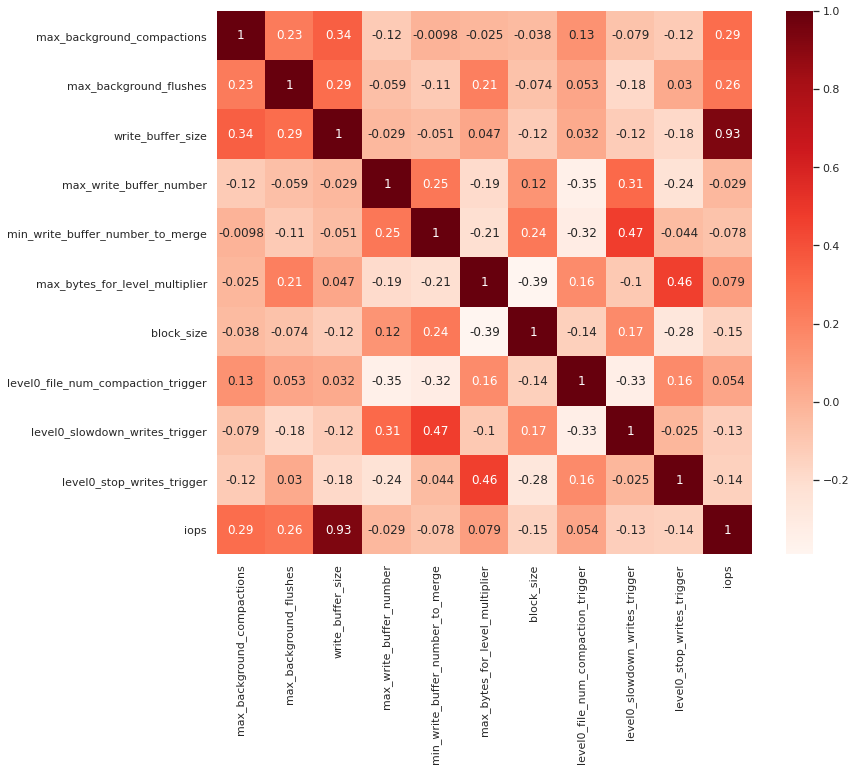

In [16]:
# Correlation between features and output
plt.figure(figsize=(12,10))

corr = dataset_x_normalized.corr()
sns.heatmap(corr, annot=True, cmap = plt.cm.Reds)

In [58]:
dataset_x.sort_values(['iops'],ascending=False).head(10)

,max_background_compactions,max_background_flushes,write_buffer_size,max_write_buffer_number,min_write_buffer_number_to_merge,max_bytes_for_level_multiplier,block_size,level0_file_num_compaction_trigger,level0_slowdown_writes_trigger,level0_stop_writes_trigger,iops
58,256,10,130000000,11,2,15.0,29730,229,1,718,108337.0
2,256,10,130000000,10,2,15.0,36665,230,1,664,108335.0
0,256,10,130000000,11,2,15.0,29548,229,1,717,108323.0
84,256,10,130000000,11,2,15.0,29983,229,1,718,108319.0
11,256,10,130000000,11,2,15.0,30850,229,1,715,108229.0
41,256,10,130000000,15,2,15.0,48954,225,66,670,108204.0
4,256,10,130000000,11,2,15.0,30630,229,1,716,108185.0
94,256,10,130000000,11,2,15.0,30751,229,1,713,108176.0
33,256,10,130000000,11,2,15.0,32937,229,1,688,108171.0
97,256,10,130000000,10,2,15.0,35433,229,1,671,108166.0


In [60]:
dataset_x.sort_values(['write_buffer_size'],ascending=True).head(10)


,max_background_compactions,max_background_flushes,write_buffer_size,max_write_buffer_number,min_write_buffer_number_to_merge,max_bytes_for_level_multiplier,block_size,level0_file_num_compaction_trigger,level0_slowdown_writes_trigger,level0_stop_writes_trigger,iops
372,256,10,1,128,1,5.0,500000,256,1024,1,5969.0
172,1,10,1,128,25,15.0,1,1,1024,1024,4007.0
150,11,5,66216,86,28,9.0,391282,230,101,213,17240.0
300,172,7,419807,26,20,12.0,203366,191,465,376,28524.0
186,174,3,528268,116,24,10.0,12262,58,786,682,28786.0
327,170,4,584180,69,14,10.0,404447,197,416,1010,30066.0
323,30,4,665497,118,6,9.0,70605,21,192,683,34993.0
242,130,10,868943,32,6,6.0,259691,115,740,350,25606.0
285,147,3,954919,43,17,13.0,209801,220,372,796,33427.0
114,5,4,1021525,28,12,10.0,181711,164,549,439,35890.0


In [28]:

dataset_opt = pd.read_csv("slo_opt.csv", index_col = 0)
params_opt = pd.read_csv("params_opt.csv", index_col = 0)
params_opt['iops'] = dataset_opt['mixgraph_iops']

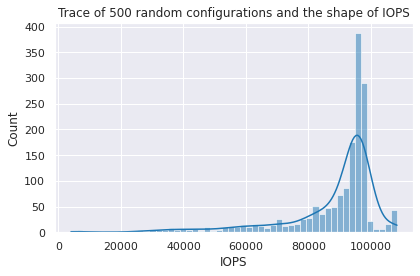

In [29]:
fig, ax = plt.subplots()
sns.histplot(data=dataset_opt, x='mixgraph_iops', kde=True)
ax.set(xlabel='IOPS', ylabel ='Count', title='Trace of 500 random configurations and the shape of IOPS')
plt.tight_layout()
fig.savefig(paper_path / 'opt_iops.pdf', format='pdf', dpi=300)


In [31]:
corr = params_opt.corr()

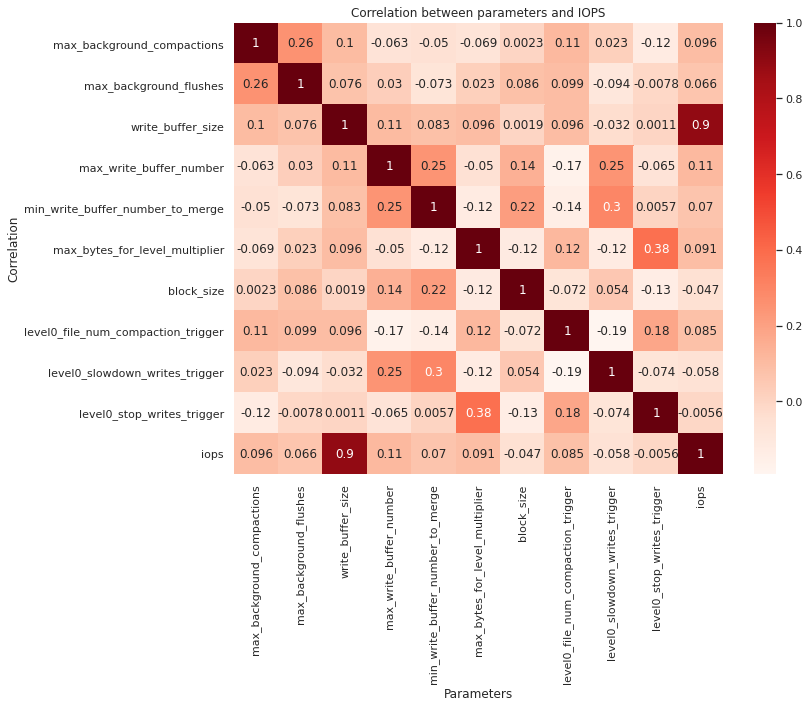

In [32]:
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(corr, annot=True, cmap = plt.cm.Reds)
ax.set(xlabel='Parameters', ylabel ='Correlation',
       title='Correlation between parameters and IOPS')
plt.tight_layout()
fig.savefig(paper_path / 'opt_corr.pdf', format='pdf', dpi=300)

In [33]:

params_opt.sort_values(by='iops', ascending=False).head(10)

,max_background_compactions,max_background_flushes,write_buffer_size,max_write_buffer_number,min_write_buffer_number_to_merge,max_bytes_for_level_multiplier,block_size,level0_file_num_compaction_trigger,level0_slowdown_writes_trigger,level0_stop_writes_trigger,iops
164,120,4,130000000,46,2,9.792984,318021,99,920,1024,108348.0
58,256,10,130000000,11,2,15.000000,29730,229,1,718,108337.0
2,256,10,130000000,10,2,15.000000,36665,230,1,664,108335.0
0,256,10,130000000,11,2,15.000000,29548,229,1,717,108323.0
84,256,10,130000000,11,2,15.000000,29983,229,1,718,108319.0
11,256,10,130000000,11,2,15.000000,30850,229,1,715,108229.0
41,256,10,130000000,15,2,15.000000,48954,225,66,670,108204.0
4,256,10,130000000,11,2,15.000000,30630,229,1,716,108185.0
94,256,10,130000000,11,2,15.000000,30751,229,1,713,108176.0
33,256,10,130000000,11,2,15.000000,32937,229,1,688,108171.0
